In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

from sklearn.linear_model import Lasso

In [4]:
dataset = pd.read_csv("../Datasets/50_Startups.csv")
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [8]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

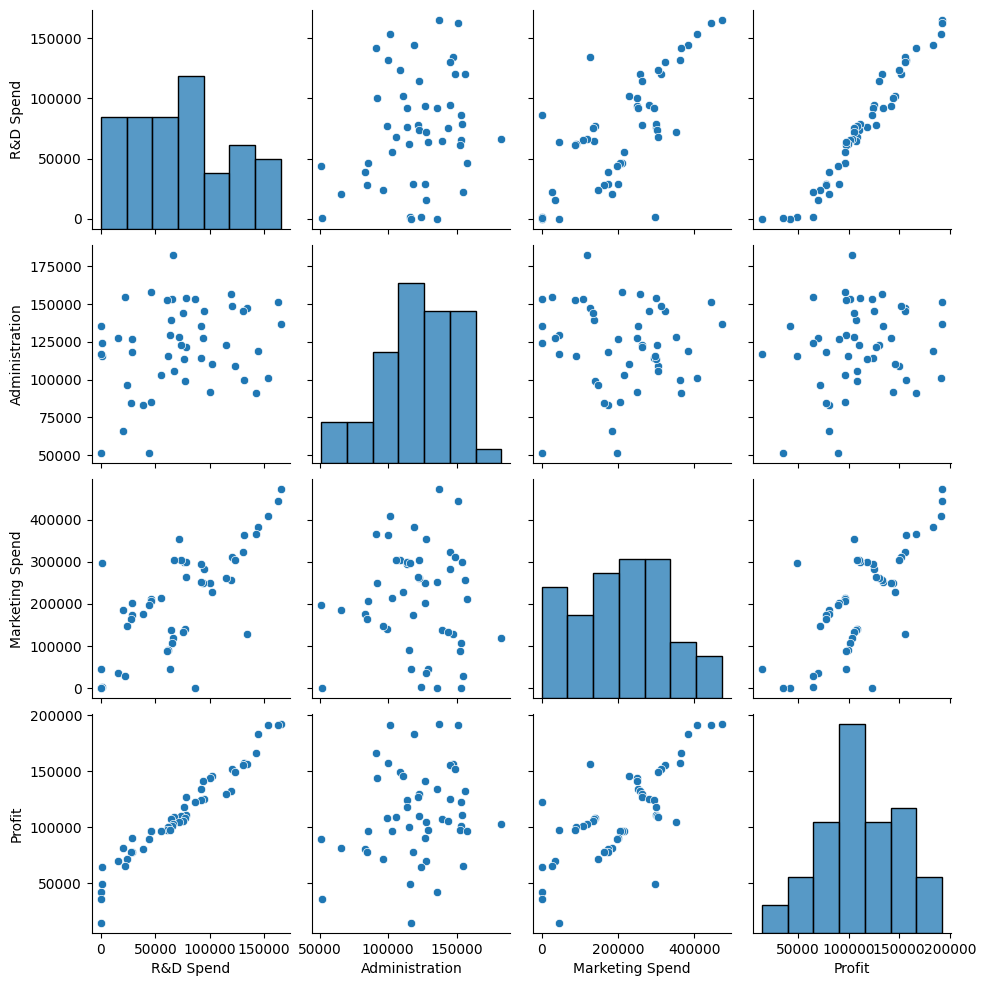

In [4]:
sns.pairplot(dataset.iloc[:, [0,1,2,4]])

Administración no tiene tan buena correlación con las otras variables independientes, se puede considerar dropear

In [5]:
dataset.iloc[:, [0,1,2,4]].corr()

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


<Axes: >

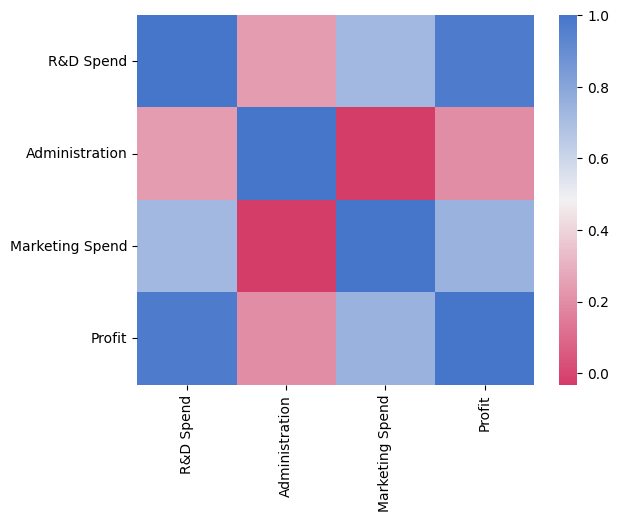

In [6]:
cmap = sns.diverging_palette(0, 255, as_cmap=True)
sns.heatmap(dataset.iloc[:, [0,1,2,4]].corr(), cmap=cmap)

In [9]:
MyLabelEnconder_X = LabelEncoder()
X[:, 3] = MyLabelEnconder_X.fit_transform(X[:, 3])
transformer = [('one_hot_encoder', OneHotEncoder(categories='auto'), [3])]
ct = ColumnTransformer(transformer, remainder='passthrough')
np.set_printoptions(suppress=True, precision=2)
X = np.array(ct.fit_transform(X), dtype=np.float64)
X = X[:, 1:]

Si un valor VIF excede los 10 puntos, podemos considerar dropear alguna columna por temas de multicolinealidad

In [10]:
def calc_vif(X, features):
    X = pd.DataFrame(X)
    vif = pd.DataFrame()
    vif["variables"] = features
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif
features = ['Florida','New York','R&D Spend', 'Administration', 'Marketing Spend']
calc_vif(X, features)


,variables,VIF
0,Florida,2.004519
1,New York,1.928836
2,R&D Spend,8.451019
3,Administration,4.950277
4,Marketing Spend,8.092278


In [11]:
x_train, x_test, y_train, y_test =  train_test_split(X, y, test_size=1/5, random_state = 0)

In [18]:
lasso_regression = Lasso(alpha=10) 
lasso_regression.fit(x_train, y_train)
y_pred = lasso_regression.predict(x_test)

In [19]:
print("Coeficientes:", lasso_regression.coef_)
print("Intercepción:", lasso_regression.intercept_)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

Coeficientes: [-916.32  668.49    0.77    0.03    0.04]
Intercepción: 42573.40335741354
RMSE: 9121.49709104485
MAE: 7500.149889571333
R^2: 0.9349423284685403


In [10]:
MyRegression = LinearRegression().fit(x_train, y_train)
y_pred = MyRegression.predict(x_test)

Interpretar coeficientes

Esto puede no tener un significado real, es poco probable que todas las variables independientes sean cero 

In [11]:
MyRegression.intercept_

42554.16761776614


* Florida (-959.28): coef negativo de -959 indica que hay menor profit si el estado es Florida
* New York (699.37): esto indica que hay mayor profit cuando el estado es New York
* R&D Spend (0.77): indica cuánto cambia el Profit por cada unidad adicional de gasto en investigación y desarrollo. Un coeficiente positivo indica que, en promedio, un mayor gasto en investigación y desarrollo está asociado con un aumento en el Profit.
* Administration (0.03): En promedio, un mayor gasto en administración está asociado con un aumento en el Profit, aunque el efecto parece ser muy pequeño en comparación con R&D.
* Marketing Spend (0.04): En promedio, un mayor gasto en marketing está asociado con un aumento en el Profit, aunque el efecto parece ser muy pequeño en comparación con R&F.

In [12]:
MyRegression.coef_

[-959.28  699.37    0.77    0.03    0.04]


Desviación de la dimensión Profit

In [38]:
dataset["Profit"].std()

40306.18033765055

- El RMSE y MSA tiene valores menores a la desviación de Profit, lo que indica que el modelo está haciendo predicciones que son mucho mejores que simplemente predecir el promedio de los datos
- El R2 tiene un valor cercano a 1, lo que significa que el modelo tuvo un buen desempeño en las predicciones

In [37]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MSA:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE: 9137.99015279116
MSA: 7514.293659636894
R2: 0.9347068473282966


Usando Backward Elimination para seleccionar las mejores dimensiones para usar en nuestro modelo

In [14]:
X = np.append(arr = np.ones((50,1)).astype(int), values = X, axis = 1)

In [21]:
X_opt = X[:, [0, 1, 2, 3, 4, 5]]
regressionOLS = sm.OLS(y, X_opt).fit()
regressionOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           1.34e-27
Time:                        21:48:46   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.013e+04   6884.820      7.281      0.000    3.62e+04     6.4e+04
x1           198.7888   3371.007      0.059      0.953   -6595.030    6992.607
x2           -41.8870   3256.039     -0.013      0.990   -6604.003    6520.229
x3             0.8060      0.046     17.369      0.000       0.712       0.900
x4            -0.0270      0.052     -0.517      0.608      -0.132       0.078
x5             0.0270      0.017      1.574      0.123      -0.008       0.062
==============================================================================
Omnibus:                       14.782   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.266
Skew:                          -0.948   Prob(JB):                     2.41e-05
Kurtosis:                       5.572   Cond. No.                     1.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
def backwardEliminationPvalue(X, sl):    
    n = len(X[0])    
    for i in range(0, n):        
        regressionOLS = sm.OLS(y, X.tolist()).fit()        
        maxval = max(regressionOLS.pvalues).astype(float)        
        if maxval > sl:            
            for j in range(0, n - i):                
                if (regressionOLS.pvalues[j].astype(float) == maxval):                    
                    X = np.delete(X, j, 1)    
    regressionOLS.summary()
    return X_Modeled
SL = 0.05
X_opt = X[:, [0, 1, 2, 3, 4, 5]]
X_Modeled = backwardEliminationPvalue(X_opt, SL)
X_Modeled

array([[     1.  , 165349.2 ],
       [     1.  , 162597.7 ],
       [     1.  , 153441.51],
       [     1.  , 144372.41],
       [     1.  , 142107.34],
       [     1.  , 131876.9 ],
       [     1.  , 134615.46],
       [     1.  , 130298.13],
       [     1.  , 120542.52],
       [     1.  , 123334.88],
       [     1.  , 101913.08],
       [     1.  , 100671.96],
       [     1.  ,  93863.75],
       [     1.  ,  91992.39],
       [     1.  , 119943.24],
       [     1.  , 114523.61],
       [     1.  ,  78013.11],
       [     1.  ,  94657.16],
       [     1.  ,  91749.16],
       [     1.  ,  86419.7 ],
       [     1.  ,  76253.86],
       [     1.  ,  78389.47],
       [     1.  ,  73994.56],
       [     1.  ,  67532.53],
       [     1.  ,  77044.01],
       [     1.  ,  64664.71],
       [     1.  ,  75328.87],
       [     1.  ,  72107.6 ],
       [     1.  ,  66051.52],
       [     1.  ,  65605.48],
       [     1.  ,  61994.48],
       [     1.  ,  61136.38],
       [

In [30]:
def backwardEliminationPAndR2(X, SL):
    n = len(X[0])
    temp = np.zeros((50,6)).astype(int)
    for i in range(0, n):
        regressor_OLS = sm.OLS(y, X.tolist()).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, n - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = X[:, j]
                    X = np.delete(X, j, 1)
                    tmp_regressor = sm.OLS(y, X.tolist()).fit()   
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):  
                        x_rollback = np.hstack((X, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()    
    return X_Modeled
SL = 0.05
X_opt = X[:, [0, 1, 2, 3, 4, 5]]
X_Modeled = backwardEliminationPAndR2(X_opt, SL)
X_Modeled

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     450.8
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           2.16e-31
Time:                        21:54:13   Log-Likelihood:                -525.54
No. Observations:                  50   AIC:                             1057.
Df Residuals:                      47   BIC:                             1063.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.698e+04   2689.933     17.464      0.0

array([[     1.  , 165349.2 , 471784.  ],
       [     1.  , 162597.7 , 443898.  ],
       [     1.  , 153441.51, 407934.  ],
       [     1.  , 144372.41, 383199.  ],
       [     1.  , 142107.34, 366168.  ],
       [     1.  , 131876.9 , 362861.  ],
       [     1.  , 134615.46, 127716.  ],
       [     1.  , 130298.13, 323876.  ],
       [     1.  , 120542.52, 311613.  ],
       [     1.  , 123334.88, 304981.  ],
       [     1.  , 101913.08, 229160.  ],
       [     1.  , 100671.96, 249744.  ],
       [     1.  ,  93863.75, 249839.  ],
       [     1.  ,  91992.39, 252664.  ],
       [     1.  , 119943.24, 256512.  ],
       [     1.  , 114523.61, 261776.  ],
       [     1.  ,  78013.11, 264346.  ],
       [     1.  ,  94657.16, 282574.  ],
       [     1.  ,  91749.16, 294919.  ],
       [     1.  ,  86419.7 ,      0.  ],
       [     1.  ,  76253.86, 298664.  ],
       [     1.  ,  78389.47, 299737.  ],
       [     1.  ,  73994.56, 303319.  ],
       [     1.  ,  67532.53, 3047